In [1]:
import inspect
import os
import sys
from typing import List, Dict, Tuple, Optional

from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor
from torchvision.models.detection.roi_heads import RoIHeads, fastrcnn_loss
from torchvision.ops import MultiScaleRoIAlign

from common.data import DataGenerator

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

import cv2
import mlflow
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn

from src.common.conics import plot_conics, crater_representation, ellipse_axes, ellipse_angle, conic_center
from src.detection import create_detection_model
from src.detection.training import get_dataloaders

In [2]:
mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("crater-detection")

In [3]:
dataset_path = "../data/dataset_2c6e817a-238f-4872-a17a-5896686b837a.h5"
batch_size = 10
num_workers = 4

train_loader, validation_loader, test_loader = get_dataloaders(dataset_path, batch_size, num_workers)

In [4]:
device = torch.device('cpu')
model = create_detection_model()
model.to(device)

checkpoint = mlflow.pytorch.load_state_dict(r'../artifacts/1/fb52f4caddb7419bb2ac35a2cd1cbbe1/artifacts/checkpoint')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print()

In [5]:
images, targets = next(iter(test_loader))
with torch.no_grad():
    out = model(images)
out

[{'boxes': tensor([[1.8846e+02, 5.5516e+01, 2.0098e+02, 6.7752e+01],
          [7.6128e+01, 1.5525e+02, 9.4078e+01, 1.7056e+02],
          [2.5867e+01, 2.4359e+02, 3.7618e+01, 2.5418e+02],
          [1.3938e+02, 1.9004e+02, 1.5126e+02, 2.0294e+02],
          [2.0280e+02, 2.0052e+01, 2.1659e+02, 3.4009e+01],
          [2.3162e+02, 1.2057e+02, 2.4115e+02, 1.3125e+02],
          [1.0760e+02, 1.3085e+02, 1.2076e+02, 1.4299e+02],
          [2.3313e+02, 8.0966e+01, 2.4643e+02, 9.4770e+01],
          [1.2281e+02, 1.2900e+02, 1.3237e+02, 1.3734e+02],
          [2.1339e+02, 2.2877e+01, 2.2407e+02, 3.3667e+01],
          [8.1010e+00, 0.0000e+00, 6.5147e+01, 3.3825e+01],
          [3.7638e+01, 1.6829e+02, 5.2515e+01, 1.8128e+02],
          [7.7544e+01, 2.5792e+01, 9.0177e+01, 3.5915e+01],
          [1.3581e+02, 6.2334e+01, 1.4728e+02, 7.4271e+01],
          [2.5911e+01, 1.1413e+02, 3.9810e+01, 1.2725e+02],
          [2.0905e+02, 2.2850e+02, 2.1884e+02, 2.3732e+02],
          [1.5090e+02, 5.9859e+

In [6]:
test_masks = out[0]['masks']
test_scores = out[0]['scores']
test_masks = test_masks[test_scores > 0.98]

### Baseline

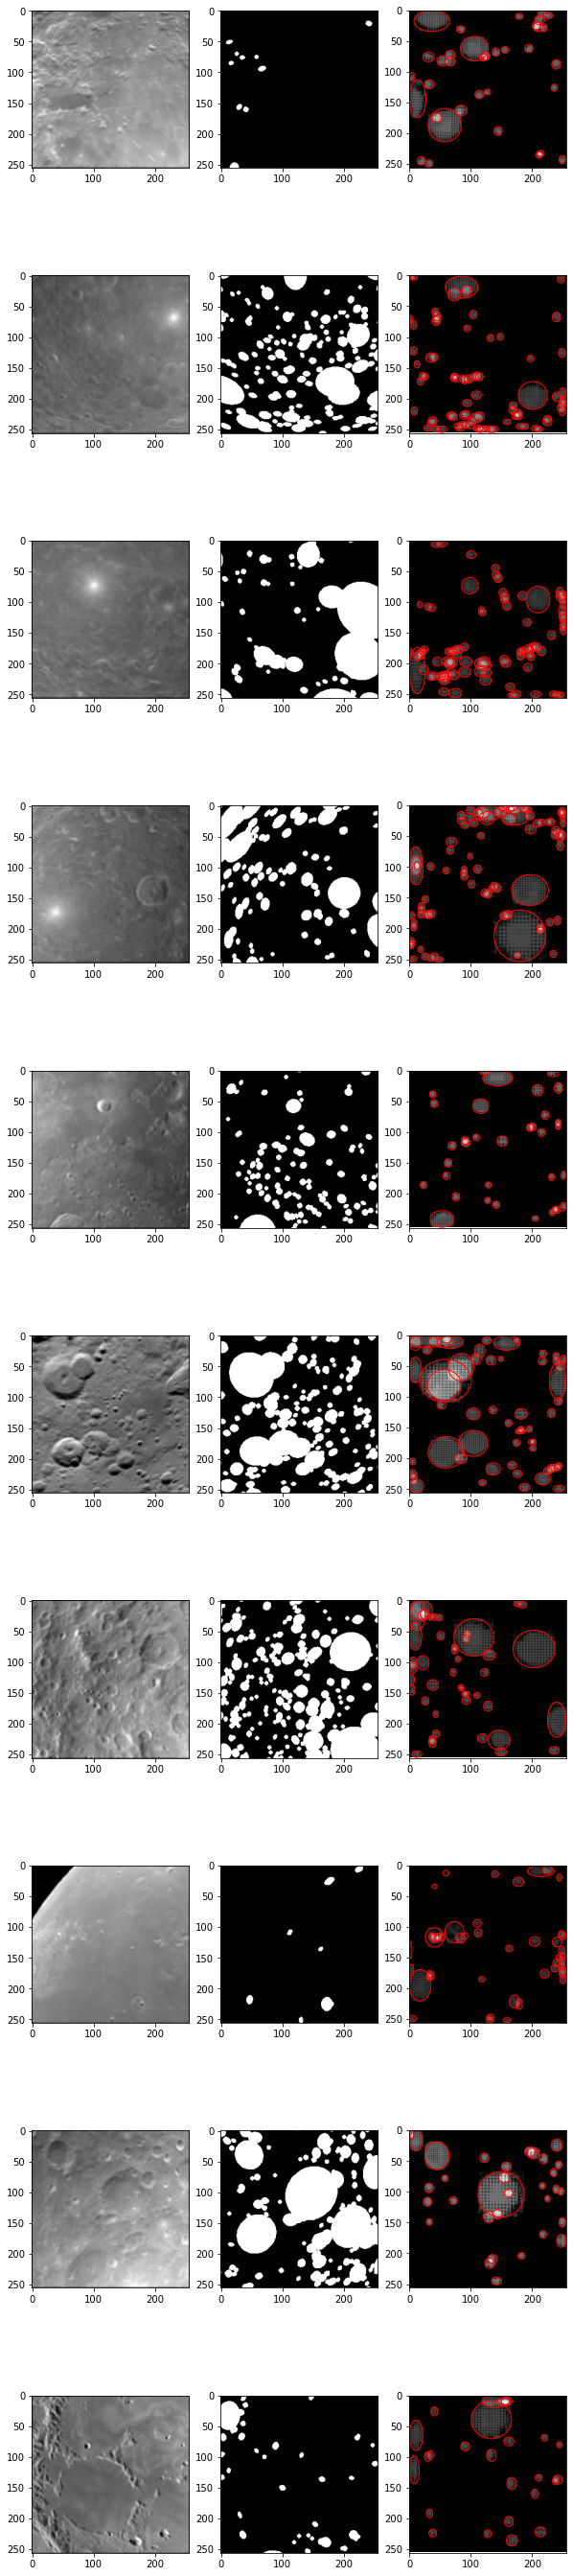

In [7]:
fig, axes = plt.subplots(len(out), 3, figsize=(10, len(out)*5))
for j in range(len(out)):
    test_masks = out[j]['masks']
    target_masks = targets[j]['masks']
    test_scores = out[j]['scores']
    test_masks = test_masks[test_scores > 0.5]
    for i in range(test_masks.shape[0]):
        cnt = np.array(np.where(test_masks[i, 0].numpy() > 0.0)).T[:, None, :]
        cnt[..., [0, 1]] = cnt[..., [1, 0]]
        (x, y), (a, b), psi = cv2.fitEllipse(cnt)
        psi = np.radians(psi)
        A = crater_representation(a, b, psi, x, y)
        plot_conics(A, ax=axes[j, 2])

    axes[j, 0].imshow(images[j][0].numpy(), cmap='gray')
    axes[j, 1].imshow(np.sum(target_masks.numpy(), axis=0), cmap='gray')
    axes[j, 2].imshow(np.sum(test_masks.numpy(), axis=0)[0], cmap='gray')


In [8]:
model.train()
model(images, targets)

{'loss_classifier': tensor(0.5702, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.3657, grad_fn=<DivBackward0>),
 'loss_mask': tensor(1.1067, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_objectness': tensor(0.3981, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.5484, grad_fn=<DivBackward0>)}

In [10]:
generator = DataGenerator.from_robbins_dataset(file_path="../data/lunar_crater_database_robbins_2018.csv")

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [11]:
generator.set_random_position()
while generator.solar_incidence_angle < 30:
    generator.set_random_position()
image, mask = map(torch.as_tensor, generator.image_mask_pair())

mask: torch.Tensor = mask.int()

obj_ids = mask.unique()[1:]
masks = mask == obj_ids[:, None, None]
num_objs = len(obj_ids)

boxes = torch.zeros((num_objs, 4), dtype=torch.float32)

for i in range(num_objs):
    pos = torch.where(masks[i])
    xmin = pos[1].min()
    xmax = pos[1].max()
    ymin = pos[0].min()
    ymax = pos[0].max()
    boxes[i] = torch.tensor([xmin, ymin, xmax, ymax])

area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
area_filter = area > 4

masks, obj_ids, boxes, area = map(lambda x: x[area_filter], (masks, obj_ids, boxes, area))

num_objs = len(obj_ids)

labels = torch.ones((num_objs,), dtype=torch.int64)
masks = masks.int()
image_id = torch.tensor([0])

iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

target = dict(
    boxes=boxes,
    labels=labels,
    masks=masks,
    image_id=image_id,
    area=area,
    iscrowd=iscrowd
)

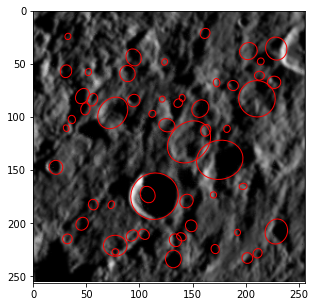

In [12]:
generator.plot(figsize=(5,5))
plt.imshow(generator.generate_image(), cmap='gray')

In [13]:
Q_proposals = torch.zeros((len(boxes), 3))

Q_proposals[:, 0] = boxes[:, 0] + (boxes[:, 2] - boxes[:, 0])/2
Q_proposals[:, 1] = boxes[:, 1] + (boxes[:, 3] - boxes[:, 1])/2
Q_proposals[:, 2] = torch.sqrt((boxes[:, 2] - boxes[:, 0])**2 + (boxes[:, 2] - boxes[:, 0])**2)

In [14]:
A_craters = generator.craters_in_image()
E_proposals = np.zeros((len(A_craters), 5))

x, y = conic_center(A_craters).T
a, b = ellipse_axes(A_craters)
angle = ellipse_angle(A_craters)

In [15]:
E_proposals[:, 0] = x
E_proposals[:, 1] = y
E_proposals[:, 2] = a
E_proposals[:, 3] = b
E_proposals[:, 4] = angle
E_proposals = torch.as_tensor(E_proposals)

In [16]:
d_x = (E_proposals[:, 0] - Q_proposals[:, 0])/Q_proposals[:, 2]
d_y = (E_proposals[:, 1] - Q_proposals[:, 1])/Q_proposals[:, 2]
d_a = torch.log(2*E_proposals[:, 2]/Q_proposals[:, 2])
d_b = torch.log(2*E_proposals[:, 3]/Q_proposals[:, 2])
d_angle = E_proposals[:, 4]/np.pi

NameError: name 'EllipseMLP' is not defined